#Preprocessing
In this section:
* The dataset is loaded
* Unnecessary columns are removed
* Missing values are imputed using linear regression
* Categorical features are encoded to trainable datatypes

In [1]:
# import libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn

from sklearn.linear_model import LinearRegression



In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Warfarin Data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6256 entries, 0 to 6255
Data columns (total 68 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   PharmGKB Subject ID                                                     6256 non-null   object 
 1   PharmGKB Sample ID                                                      6256 non-null   object 
 2   Project Site                                                            6256 non-null   int64  
 3   Gender                                                                  6252 non-null   object 
 4   Race (Reported)                                                         5750 non-null   object 
 5   Race (OMB)                                                              6256 non-null   object 
 6   Ethnicity (Reported)                                                    5017 non

In [3]:
_data = data.copy()
_data = _data[~(_data['Weight (kg)'].isnull() & _data['Height (cm)'].isnull())]
_data = _data[~(_data['Race (OMB)'].isnull() | _data['Gender'].isnull())]

RACE = 'Race (OMB)'
DOSE = 'Therapeutic Dose of Warfarin'
GROUP = 'dose_group'

def _group(x, lower, upper):
    if x[DOSE] < lower:
        return 'low'
    elif x[DOSE] > upper:
        return 'high'
    else:
        return 'inter'

_data[GROUP] = 'none'

for race in _data[RACE].unique():
    dist = _data[_data[RACE] == race][DOSE].describe()
    _data.loc[_data[RACE] == race, GROUP] = _data[_data[RACE] == race].apply(
        lambda x: _group(x, float(dist['25%']), float(dist['75%'])), axis=1)


In [4]:
Dummy_categor = pd.get_dummies(_data[['Weight (kg)',
                              'Height (cm)',
                              'Race (OMB)',
                              'Gender']],
                              columns=['Race (OMB)', 'Gender'])

train_H = Dummy_categor[(Dummy_categor['Height (cm)'].isnull() == False) & (Dummy_categor['Weight (kg)'].isnull() == False)]
pred_H = Dummy_categor[(Dummy_categor['Height (cm)'].isnull())]

x_train_H = train_H.drop(['Height (cm)'], axis='columns')
y_train_H = train_H['Height (cm)']
x_pred_H = pred_H.drop(['Height (cm)'], axis='columns')

linreg = LinearRegression()
linreg.fit(x_train_H, y_train_H)
imputed_heights = linreg.predict(x_pred_H)



In [5]:
train_W = Dummy_categor[(Dummy_categor['Weight (kg)'].isnull() == False) & (Dummy_categor['Height (cm)'].isnull() == False)]
pred_W = Dummy_categor[(Dummy_categor['Weight (kg)'].isnull())]

x_train_W = train_W.drop(['Weight (kg)'], axis='columns')
y_train_W = train_W['Weight (kg)']
x_pred_W = pred_W.drop(['Weight (kg)'], axis='columns')

linreg = LinearRegression()
linreg.fit(x_train_W, y_train_W)
imputed_weights = linreg.predict(x_pred_W)


In [6]:
_data.loc[_data['Height (cm)'].isnull(), 'Height (cm)'] = imputed_heights
_data.loc[_data['Weight (kg)'].isnull(), 'Weight (kg)'] = imputed_weights

assert(_data[['Height (cm)', 'Weight (kg)']].isnull().values.any() == False)


In [7]:
def _impute_vkorc1_row(row: pd.Series):

    rs2359612 = row['VKORC1 genotype:   2255C>T (7566); chr16:31011297; rs2359612; A/G']
    rs9934438 = row['VKORC1 genotype:   1173 C>T(6484); chr16:31012379; rs9934438; A/G']
    rs9923231 = row['VKORC1 genotype:   -1639 G>A (3673); chr16:31015190; rs9923231; C/T']
    rs8050894 = row['VKORC1 genotype:   1542G>C (6853); chr16:31012010; rs8050894; C/G']
    race = row['Race (OMB)']
    black_missing_mixed = [
        'Black or African American',
        'Missing or Mixed Race']

    if rs9923231 in ['A/A', 'A/G', 'G/A', 'G/G']:
        return rs9923231
    elif race not in black_missing_mixed and rs2359612 == 'C/C':
        return 'G/G'
    elif race not in black_missing_mixed and rs2359612 == 'T/T':
        return 'A/A'
    elif rs9934438 == 'C/C':
        return 'G/G'
    elif rs9934438 == 'T/T':
        return 'A/A'
    elif rs9934438 == 'C/T':
        return 'A/G'
    elif race not in black_missing_mixed and rs8050894 == 'G/G':
        return 'G/G'
    elif race not in black_missing_mixed and rs8050894 == 'C/C':
        return 'A/A'
    elif race not in black_missing_mixed and rs8050894 == 'C/G':
        return 'A/G'
    else:
        return 'Unknown'

_data['Imputed VKORC1'] = _data.apply(_impute_vkorc1_row, axis=1)
_data.loc[_data['CYP2C9 consensus'].isna(), 'CYP2C9 consensus'] = 'Unknown'


In [8]:
FILTER_COLUMNS = [
    'Age',
    'Therapeutic Dose of Warfarin',
    'Subject Reached Stable Dose of Warfarin',
    'Gender',
    'CYP2C9 consensus',
    'Imputed VKORC1',
]

missing_rows = _data[ FILTER_COLUMNS ].isnull().any(axis=1)
_data = _data[~missing_rows]

In [9]:
RARE_ALLELES = [
    '*1/*5',
    '*1/*6',
    '*1/*11',
    '*1/*13',
    '*1/*14',
]
_data = _data[_data['CYP2C9 consensus'].isin(RARE_ALLELES) == False]

In [10]:
_data = _data[_data['Therapeutic Dose of Warfarin'] < 315]

In [11]:
IWPC_PARAMS = [
    "Race (OMB)",
    "Age",
    "Height (cm)",
    "Weight (kg)",
    "Amiodarone (Cordarone)",
    "Carbamazepine (Tegretol)",
    "Phenytoin (Dilantin)",
    "Rifampin or Rifampicin",
    "Current Smoker",
    "CYP2C9 consensus",
    "Imputed VKORC1",
    "Therapeutic Dose of Warfarin",
    'INR on Reported Therapeutic Dose of Warfarin',
]

assert(isinstance(_data, pd.DataFrame))


_data = pd.get_dummies(_data[IWPC_PARAMS])
_data = _data.fillna(value=0)
assert(_data.isnull().values.any() == False)

data.drop(['INR on Reported Therapeutic Dose of Warfarin'], axis='columns', inplace=True)
_data.to_csv('output.csv', index=False)


In [12]:
_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5741 entries, 0 to 6255
Data columns (total 33 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Height (cm)                                   5741 non-null   float64
 1   Weight (kg)                                   5741 non-null   float64
 2   Amiodarone (Cordarone)                        5741 non-null   float64
 3   Carbamazepine (Tegretol)                      5741 non-null   float64
 4   Phenytoin (Dilantin)                          5741 non-null   float64
 5   Rifampin or Rifampicin                        5741 non-null   float64
 6   Current Smoker                                5741 non-null   float64
 7   Therapeutic Dose of Warfarin                  5741 non-null   float64
 8   INR on Reported Therapeutic Dose of Warfarin  5741 non-null   float64
 9   Race (OMB)_Asian                              5741 non-null   u

#Analysis
In this section, the processed data is analysed by:
* Plotting variation of therapeutic dose of warfarin with respect to:


>* Different race categories
>* Different age groups
>* Different genetic markers
>* Different medication taken
>* Different height and weight

In [13]:
df = _data.copy()
df.describe()

,Height (cm),Weight (kg),Amiodarone (Cordarone),Carbamazepine (Tegretol),Phenytoin (Dilantin),Rifampin or Rifampicin,Current Smoker,Therapeutic Dose of Warfarin,INR on Reported Therapeutic Dose of Warfarin,Race (OMB)_Asian,...,CYP2C9 consensus_*1/*2,CYP2C9 consensus_*1/*3,CYP2C9 consensus_*2/*2,CYP2C9 consensus_*2/*3,CYP2C9 consensus_*3/*3,CYP2C9 consensus_Unknown,Imputed VKORC1_A/A,Imputed VKORC1_A/G,Imputed VKORC1_G/G,Imputed VKORC1_Unknown
count,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,...,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000
mean,167.979150,78.794878,0.048772,0.005574,0.004529,0.000697,0.083957,31.967232,2.152263,0.263891,...,0.131510,0.083957,0.010103,0.011845,0.003484,0.022296,0.295245,0.358474,0.328166,0.018115
std,10.581973,22.316584,0.215410,0.074457,0.067150,0.026389,0.277348,16.765840,0.815865,0.440779,...,0.337987,0.277348,0.100012,0.108196,0.058925,0.147657,0.456192,0.479594,0.469586,0.133380
min,124.970000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,160.020000,63.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.020000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,167.640000,76.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,2.340000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,175.790577,90.700000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,2.600000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,202.000000,237.700000,1.000000,1.000000,1.000000,1.000000,1.000000,230.000000,6.100000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


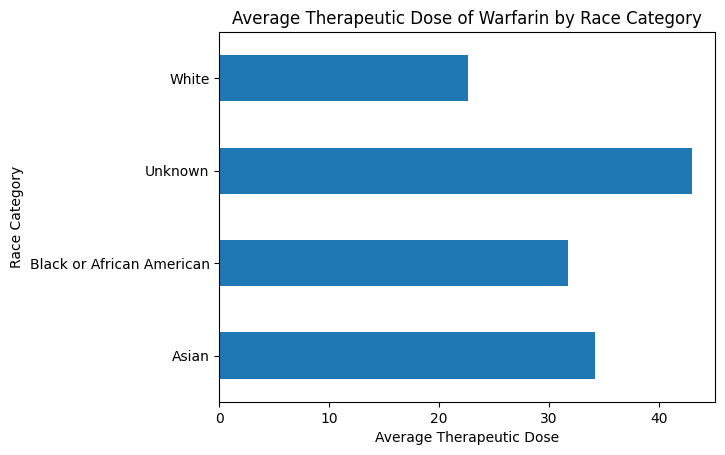

In [14]:
average_dose_by_race = df.groupby(['Race (OMB)_Asian', 'Race (OMB)_Black or African American', 'Race (OMB)_Unknown', 'Race (OMB)_White'])['Therapeutic Dose of Warfarin'].mean()

average_dose_by_race.plot(kind='barh')

plt.xlabel('Average Therapeutic Dose')
plt.ylabel('Race Category')
plt.title('Average Therapeutic Dose of Warfarin by Race Category')

custom_labels = ['Asian', 'Black or African American', 'Unknown', 'White']
plt.gca().set_yticklabels(custom_labels)

plt.show()


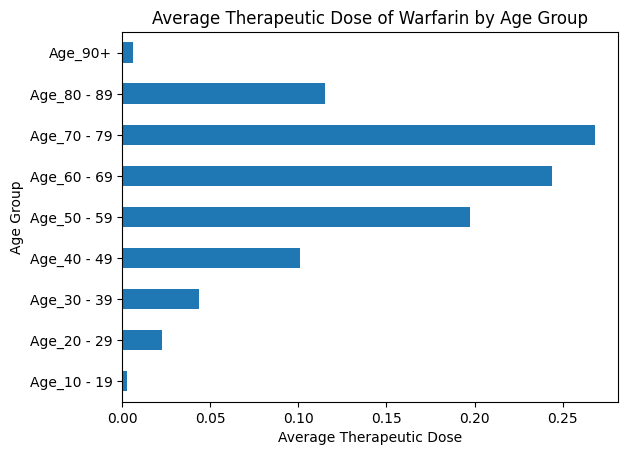

In [15]:
average_dose_by_age = df[['Age_10 - 19', 'Age_20 - 29', 'Age_30 - 39', 'Age_40 - 49', 'Age_50 - 59',
                         'Age_60 - 69', 'Age_70 - 79', 'Age_80 - 89', 'Age_90+']].mean()

average_dose_by_age.plot(kind='barh')

plt.xlabel('Average Therapeutic Dose')
plt.ylabel('Age Group')
plt.title('Average Therapeutic Dose of Warfarin by Age Group')

age_group_labels = ['Age_10 - 19', 'Age_20 - 29', 'Age_30 - 39', 'Age_40 - 49', 'Age_50 - 59',
                    'Age_60 - 69', 'Age_70 - 79', 'Age_80 - 89', 'Age_90+']
plt.gca().set_yticklabels(age_group_labels)

plt.show()


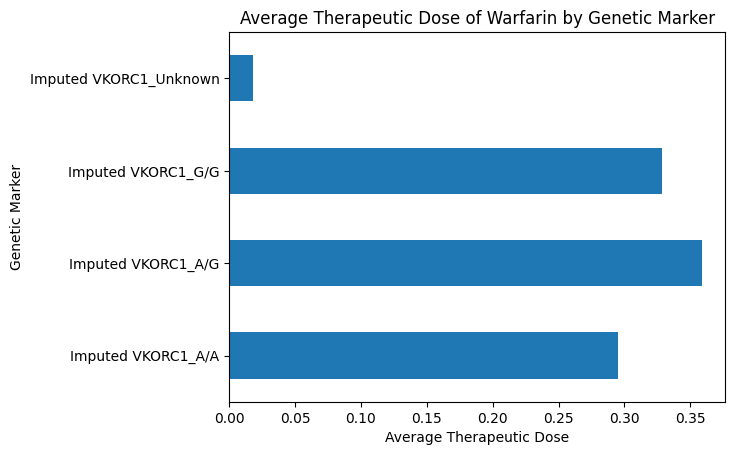

In [16]:
average_dose_by_genetic_marker = df[['Imputed VKORC1_A/A', 'Imputed VKORC1_A/G', 'Imputed VKORC1_G/G', 'Imputed VKORC1_Unknown']].mean()

average_dose_by_genetic_marker.plot(kind='barh')

plt.xlabel('Average Therapeutic Dose')
plt.ylabel('Genetic Marker')
plt.title('Average Therapeutic Dose of Warfarin by Genetic Marker')

genetic_marker_labels = ['Imputed VKORC1_A/A', 'Imputed VKORC1_A/G', 'Imputed VKORC1_G/G', 'Imputed VKORC1_Unknown']
plt.gca().set_yticklabels(genetic_marker_labels)

plt.show()


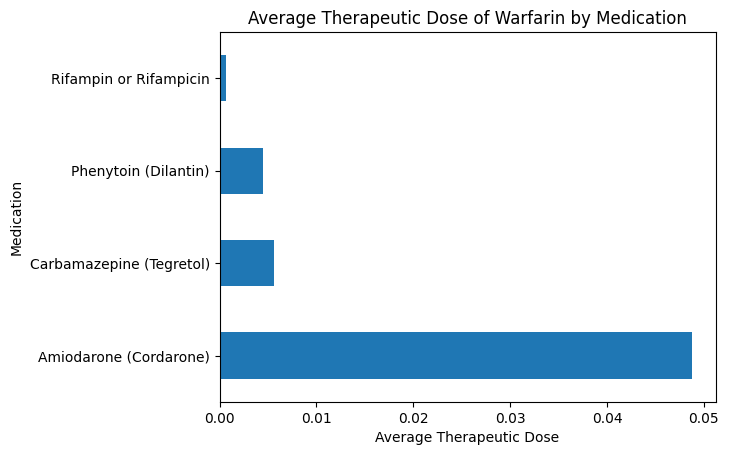

In [17]:
average_dose_by_medication = df[['Amiodarone (Cordarone)', 'Carbamazepine (Tegretol)', 'Phenytoin (Dilantin)', 'Rifampin or Rifampicin']].mean()

average_dose_by_medication.plot(kind='barh')

plt.xlabel('Average Therapeutic Dose')
plt.ylabel('Medication')
plt.title('Average Therapeutic Dose of Warfarin by Medication')

medication_labels = ['Amiodarone (Cordarone)', 'Carbamazepine (Tegretol)', 'Phenytoin (Dilantin)', 'Rifampin or Rifampicin']
plt.gca().set_yticklabels(medication_labels)

plt.show()


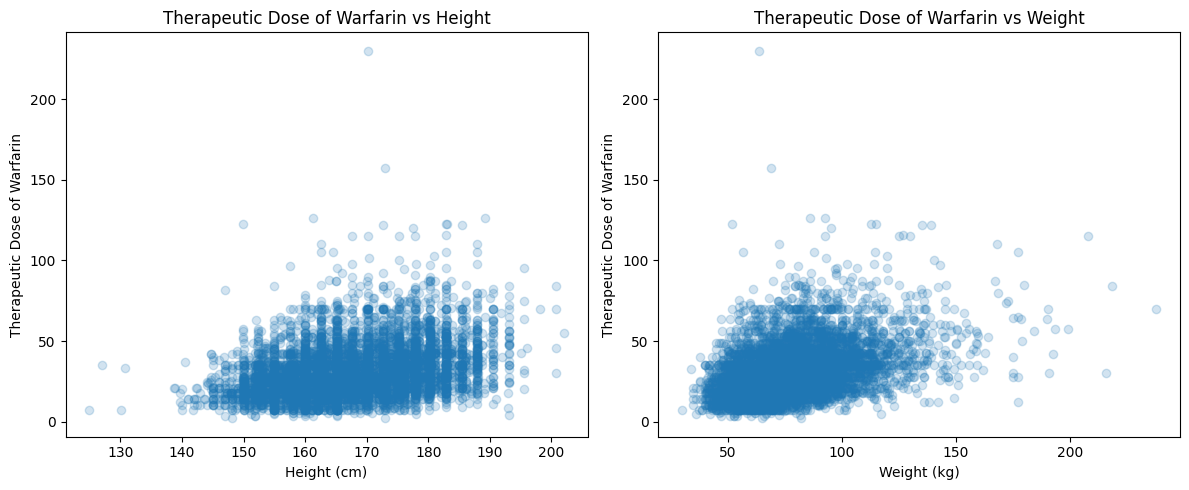

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(df['Height (cm)'], df['Therapeutic Dose of Warfarin'], alpha=0.2)
axes[0].set_xlabel('Height (cm)')
axes[0].set_ylabel('Therapeutic Dose of Warfarin')
axes[0].set_title('Therapeutic Dose of Warfarin vs Height')

axes[1].scatter(df['Weight (kg)'], df['Therapeutic Dose of Warfarin'], alpha=0.2)
axes[1].set_xlabel('Weight (kg)')
axes[1].set_ylabel('Therapeutic Dose of Warfarin')
axes[1].set_title('Therapeutic Dose of Warfarin vs Weight')

plt.tight_layout()
plt.show()



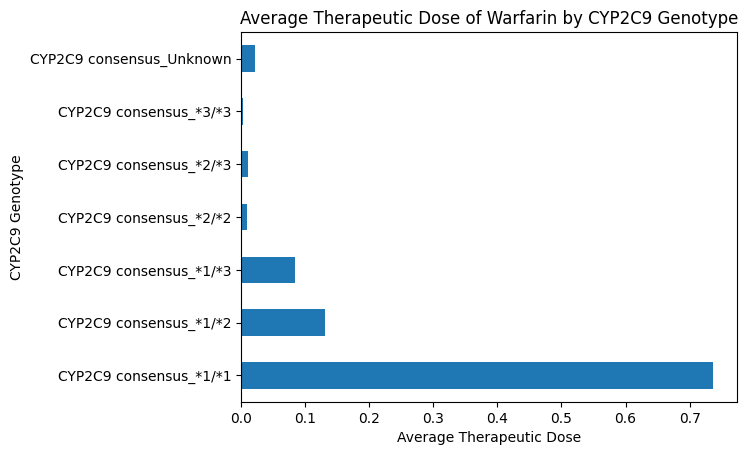

In [19]:
import matplotlib.pyplot as plt

# Group the data by CYP2C9 genotypes and calculate the average dose
average_dose_by_genotype = df[['CYP2C9 consensus_*1/*1', 'CYP2C9 consensus_*1/*2', 'CYP2C9 consensus_*1/*3', 
                              'CYP2C9 consensus_*2/*2', 'CYP2C9 consensus_*2/*3', 'CYP2C9 consensus_*3/*3', 
                              'CYP2C9 consensus_Unknown']].mean()

# Create the bar plot
average_dose_by_genotype.plot(kind='barh')

# Set labels and title
plt.xlabel('Average Therapeutic Dose')
plt.ylabel('CYP2C9 Genotype')
plt.title('Average Therapeutic Dose of Warfarin by CYP2C9 Genotype')

# Display the plot
plt.show()

In [20]:
#scaling the features (x)
from sklearn.preprocessing import StandardScaler

features = list(df.columns)
features.remove(features[7])
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

df['Therapeutic Dose of Warfarin'] = df['Therapeutic Dose of Warfarin'].apply(np.sqrt)

df

,Height (cm),Weight (kg),Amiodarone (Cordarone),Carbamazepine (Tegretol),Phenytoin (Dilantin),Rifampin or Rifampicin,Current Smoker,Therapeutic Dose of Warfarin,INR on Reported Therapeutic Dose of Warfarin,Race (OMB)_Asian,...,CYP2C9 consensus_*1/*2,CYP2C9 consensus_*1/*3,CYP2C9 consensus_*2/*2,CYP2C9 consensus_*2/*3,CYP2C9 consensus_*3/*3,CYP2C9 consensus_Unknown,Imputed VKORC1_A/A,Imputed VKORC1_A/G,Imputed VKORC1_G/G,Imputed VKORC1_Unknown
0,2.368465,1.653852,-0.226435,-0.074868,-0.067449,-0.026405,-0.302741,7.000000,0.548837,-0.598745,...,-0.389132,-0.302741,-0.101024,-0.109483,-0.059126,-0.151011,-0.647250,1.337760,-0.698901,-0.135829
1,0.808129,2.931041,-0.226435,-0.074868,-0.067449,-0.026405,3.303148,6.480741,-0.002774,-0.598745,...,-0.389132,-0.302741,-0.101024,-0.109483,-0.059126,-0.151011,1.544999,-0.747518,-0.698901,-0.135829
2,-0.512156,-0.075954,-0.226435,-0.074868,-0.067449,-0.026405,-0.302741,7.280110,-0.309224,-0.598745,...,-0.389132,-0.302741,-0.101024,-0.109483,-0.059126,-0.151011,-0.647250,-0.747518,1.430818,-0.135829
3,1.347773,0.533512,-0.226435,-0.074868,-0.067449,-0.026405,-0.302741,5.291503,0.303676,-0.598745,...,-0.389132,-0.302741,-0.101024,-0.109483,-0.059126,-0.151011,-0.647250,1.337760,-0.698901,-0.135829
4,-0.032053,-0.277615,-0.226435,-0.074868,-0.067449,-0.026405,-0.302741,6.480741,-0.309224,-0.598745,...,-0.389132,3.303148,-0.101024,-0.109483,-0.059126,-0.151011,-0.647250,1.337760,-0.698901,-0.135829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6251,0.207999,-1.152825,-0.226435,-0.074868,-0.067449,-0.026405,-0.302741,4.472136,2.877857,-0.598745,...,-0.389132,-0.302741,-0.101024,-0.109483,-0.059126,-0.151011,-0.647250,1.337760,-0.698901,-0.135829
6252,-0.992260,-0.787146,-0.226435,-0.074868,-0.067449,-0.026405,-0.302741,4.472136,-0.186644,1.670161,...,-0.389132,-0.302741,-0.101024,-0.109483,-0.059126,-0.151011,1.544999,-0.747518,-0.698901,-0.135829
6253,0.688103,0.534408,-0.226435,-0.074868,-0.067449,-0.026405,-0.302741,5.700877,0.548837,-0.598745,...,-0.389132,-0.302741,-0.101024,-0.109483,-0.059126,-0.151011,-0.647250,1.337760,-0.698901,-0.135829
6254,-0.032053,-0.116286,-0.226435,-0.074868,-0.067449,-0.026405,-0.302741,5.700877,-0.186644,-0.598745,...,-0.389132,3.303148,-0.101024,-0.109483,-0.059126,-0.151011,-0.647250,1.337760,-0.698901,-0.135829


#Machine Learning
In this section:
* Machine Learning models are imported and initizlized
* Interesting implementation techniques are performed of the training data

##Import and Build the Learning Models
In this section:
* Various machine learning models are initialized
* Stacking of machine learning models are experimented
* Pipelines are created (for experimental purposes as well)

In [21]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [22]:
#more imports
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from mlxtend.regressor import StackingCVRegressor

In [23]:
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=87dea757115f80e49e84cbeb23749e04e32714a5012231470b91d0296acbcc02
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [24]:
from sklearn.feature_selection import SelectFwe, f_regression, SelectPercentile
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler, FunctionTransformer, Normalizer
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoLarsCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, make_union
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_approximation import RBFSampler, Nystroem
from tpot.builtins import StackingEstimator, ZeroCount
from copy import copy

In [25]:
ests = []
stack_ests = []

LR = LinearRegression()
LSVR = LinearSVR()
GBT = GradientBoostingRegressor()
GBT_ = GradientBoostingRegressor(learning_rate=0.1, loss='absolute_error', max_depth=4)
SV = SVR(kernel='linear', cache_size=1000)
NN = MLPRegressor(hidden_layer_sizes=(100, ), activation='logistic', solver='lbfgs')
RR = Ridge(alpha=1.0)
Stack1 = StackingCVRegressor(regressors=[GBT_, SV, NN], meta_regressor=SV, cv=5,)
Stack2 = StackingCVRegressor(regressors=[GBT_, RR, NN], meta_regressor=RR, cv=5,)

ests.append(LR)
ests.append(LSVR)
ests.append(GBT)
ests.append(RR)
ests.append(GBT_)
ests.append(SV)
ests.append(NN)

stack_ests.append(Stack1)
stack_ests.append(Stack2)


In [26]:
pipe_ests = []

tpot = make_pipeline(
    StackingEstimator(estimator=LinearSVR(C=1.0, dual=True, epsilon=0.01,loss="epsilon_insensitive", tol=0.001,)),
    StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.6000000000000001, tol=0.01, cv=5)),
    RobustScaler(),
    StackingEstimator(estimator=RidgeCV()),
    ExtraTreesRegressor(bootstrap=True, max_features=1.0, min_samples_leaf=20, min_samples_split=2, n_estimators=100,)
)

tpot2 = make_pipeline(
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=True, max_features=0.05, min_samples_leaf=18, min_samples_split=10, n_estimators=100)),
    MaxAbsScaler(),
    StackingEstimator(estimator=ExtraTreesRegressor( bootstrap=True, max_features=0.05, min_samples_leaf=18, min_samples_split=10, n_estimators=100)),
    LassoLarsCV(normalize=True, cv=3)
)

tpot3 = make_pipeline(
    make_union(FunctionTransformer(copy, validate=True), MaxAbsScaler()),
    StackingEstimator(estimator=RidgeCV()),
    ZeroCount(),
    GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, loss="absolute_error", max_depth=3, max_features=0.9000000000000001,
                              min_samples_leaf=20, min_samples_split=8, n_estimators=100, subsample=0.55)
)

pipe_ests.append(tpot)
pipe_ests.append(tpot2)
pipe_ests.append(tpot3)

#ests.append(tpot)
#ests.append(tpot2)
#ests.append(tpot3)


##Implement The Models
In this section:
* The data is split for training and testing
* The training data is fit into the initialized machine learning models
* Resampling technique is used to improved score results and robustness of the models


In [27]:
#train test split

from sklearn.model_selection import train_test_split

target_column = 'Therapeutic Dose of Warfarin'

train, test = train_test_split(df, test_size=0.2)

x_train = train.drop([target_column], axis=1).values
y_train = train[target_column].values

x_test = test.drop([target_column], axis=1).values
y_test = test[target_column].values
y_test = np.square(y_test)


In [37]:
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, r2_score
scores = []
predictions = []

num_resamples = 100

for estimator in ests:
    mae_scores = cross_val_score(estimator, x_train, y_train, scoring='neg_mean_absolute_error', cv=KFold(n_splits=num_resamples))
    r2_scores = cross_val_score(estimator, x_train, y_train, scoring='r2', cv=KFold(n_splits=num_resamples))

    y_pred = cross_val_predict(estimator, x_train, y_train, cv=KFold(n_splits=num_resamples))

    mae_mean = -mae_scores.mean()
    r2_mean = r2_scores.mean()

    predictions.append({'Estimator': estimator.__class__.__name__, 'Predictions': y_pred}) 

    scores.append({'Estimator': estimator.__class__.__name__, 'MAE': mae_mean, 'R2': r2_mean})
    print("Estimator:", estimator.__class__.__name__)
    print("MAE:", mae_mean)
    print("R2:", r2_mean)
    print("-------------------------\n")



Estimator: LinearRegression
MAE: 0.7664103191618059
R2: 0.46726505296826565
-------------------------

Estimator: LinearSVR
MAE: 0.7637264053397353
R2: 0.46943481717275504
-------------------------

Estimator: GradientBoostingRegressor
MAE: 0.7761814407257889
R2: 0.4557551519383075
-------------------------

Estimator: Ridge
MAE: 0.7663678022757914
R2: 0.4674285941425186
-------------------------

Estimator: GradientBoostingRegressor
MAE: 0.7764465035078701
R2: 0.4559904027685823
-------------------------

Estimator: SVR
MAE: 0.7644907786821045
R2: 0.471093028210594
-------------------------

Estimator: MLPRegressor
MAE: 0.8504468655830496
R2: 0.32537720607376724
-------------------------



In [33]:
for estimator in stack_ests:
    estimator.fit(x_train, y_train)

    y_pred = estimator.predict(x_train)

    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    predictions.append({'Estimator': estimator.__class__.__name__, 'Predictions': y_pred}) 

    scores.append({'Estimator': estimator.__class__.__name__, 'MAE': mae, 'R2': r2})
    print("Estimator:", estimator.__class__.__name__)
    print("MAE:", mae)
    print("R2:", r2)
    print("-------------------------\n")

Estimator: StackingCVRegressor
MAE: 0.7404447961134306
R2: 0.5164772317891486
-------------------------

Estimator: StackingCVRegressor
MAE: 0.7435547061774387
R2: 0.5163275743389433
-------------------------



In [36]:
for estimator in pipe_ests:
    estimator.fit(x_train, y_train)

    y_pred = estimator.predict(x_train)

    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    predictions.append({'Estimator': estimator.__class__.__name__, 'Predictions': y_pred}) 

    scores.append({'Estimator': estimator.__class__.__name__, 'MAE': mae, 'R2': r2})
    print("Estimator:", estimator.__class__.__name__)
    print("MAE:", mae)
    print("R2:", r2)
    print("-------------------------\n")

Estimator: Pipeline
MAE: 0.7293489423623394
R2: 0.5398191070584444
-------------------------

Estimator: Pipeline
MAE: 0.7574639037115566
R2: 0.5054561920379564
-------------------------

Estimator: Pipeline
MAE: 0.7169910227638148
R2: 0.535400222380767
-------------------------



#Analysis
In this section:
* Predicted and actual values are plotted to visually represent the results of the machine learning models



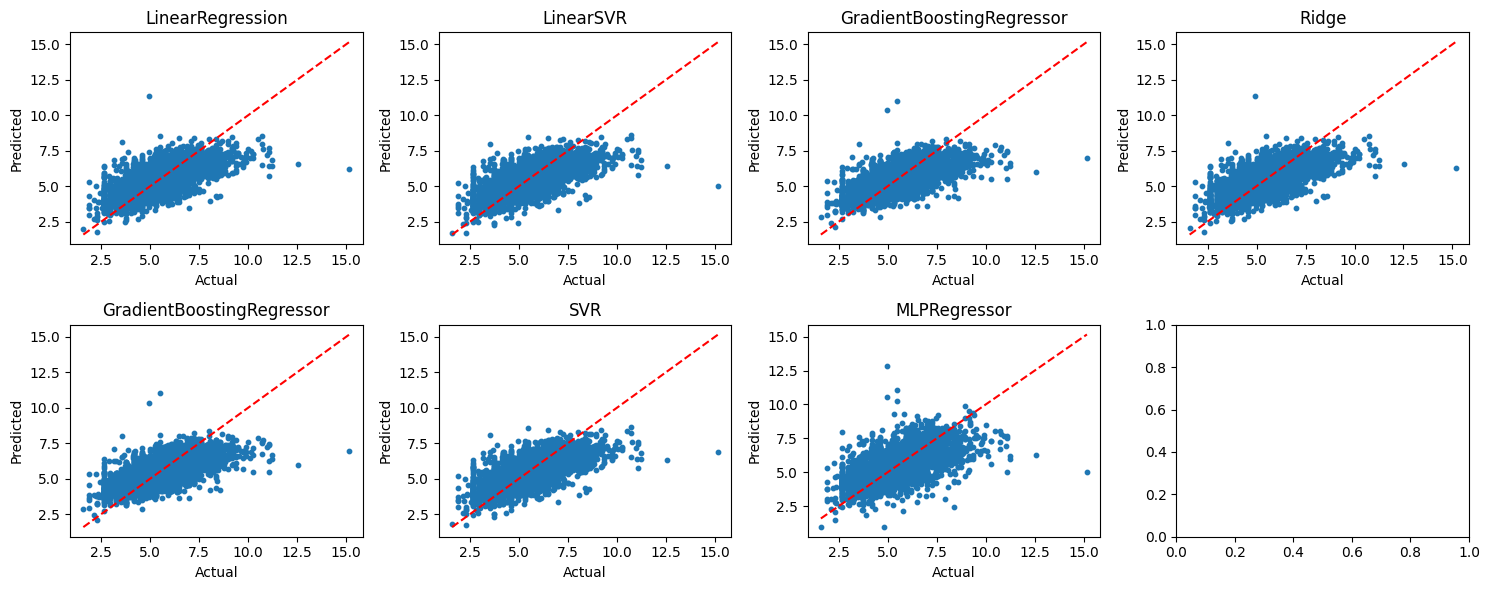

In [40]:
import matplotlib.pyplot as plt
import numpy as np

num_rows = int(np.ceil(len(ests) / 4))  
fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3)) 

for i, estimator in enumerate(ests):
    ax = axes[i // 4, i % 4]  

    pred_dict = next((item for item in predictions if item["Estimator"] == estimator.__class__.__name__), None)
    y_pred = pred_dict["Predictions"]

    ax.scatter(y_train, y_pred, s=10)
    ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--') 

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(estimator.__class__.__name__)

plt.tight_layout()
plt.show()
